# Comparison of Methods for Tackling Imbalanced Data

In this notebook, we will compare the performance of different methods on different imbalanced datasets:

- just re-sampling
- just boosting or bagging
- bagging + resamppling
- boosting + resampling
- bagging + boosting + resampling



In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
)

import xgboost

from sklearn.linear_model  import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

from imblearn.under_sampling import (
    RandomUnderSampler, 
    TomekLinks,
    EditedNearestNeighbours
)

from imblearn.combine import SMOTEENN

from imblearn.over_sampling import SMOTE

from imblearn.ensemble import (
    BalancedBaggingClassifier,
    BalancedRandomForestClassifier,
    RUSBoostClassifier,
    EasyEnsembleClassifier,
)


We create a dictionary to store our different re-samplers we want to try out.

In [2]:
# just re-sampling methods (no classifier)

resampling_dict = {
    
    # Undersampling 
    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False,
    ),
    
    # Undersampling 
    'tomek': TomekLinks(
        sampling_strategy='majority',
        n_jobs=4),
    
    # Oversampling 
    'smote': SMOTE(
        sampling_strategy='auto',
        random_state=0,
        k_neighbors=5,
        n_jobs=4),
    
    # Oversampling + Undersampling 
    'smenn': SMOTEENN(
        sampling_strategy='auto',
        random_state=0,
        smote=SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=5),
        enn=EditedNearestNeighbours(
            sampling_strategy='auto', n_neighbors=3, kind_sel='all'),
        n_jobs=4),
    
}

We create another dictionary to store the different ensemble methods we want to try out.

In [3]:
# ensemble methods (with or without resampling)

ensemble_dict = {

    # bagging of Logistic regression, no resampling
    'bagging': BaggingClassifier(
        base_estimator=LogisticRegression(random_state=2909),
        n_estimators=20,
        n_jobs=4,
        random_state=0,
    ),

    # balanced random forests (bagging)
    'balancedRF': BalancedRandomForestClassifier(
        n_estimators=20,
        criterion='gini',
        max_depth=3,
        sampling_strategy='auto',
        n_jobs=4,
        random_state=0,
    ),
    
    # bagging of Logistic regression, with resampling
    'balancedbagging': BalancedBaggingClassifier(
        base_estimator=LogisticRegression(random_state=2909),
        n_estimators=20,
        max_samples=1.0,  # The number of samples to draw from X to train each base estimator
        max_features=1.0,  # The number of features to draw from X to train each base estimator
        bootstrap=True,
        bootstrap_features=False,
        sampling_strategy='auto',
        n_jobs=4,
        random_state=0,
    ),

    # boosting + undersampling
    'rusboost': RUSBoostClassifier(
        base_estimator=None,
        n_estimators=20,
        learning_rate=1.0,
        sampling_strategy='auto',
        random_state=0,
    ),

    # bagging + boosting + under-sammpling
    'easyEnsemble': EasyEnsembleClassifier(
        n_estimators=20,
        sampling_strategy='auto',
        n_jobs=4,
        random_state=0,
    ),
}

We want to test our different methods on different imbalanced datasets provided by imblearn. We also print out the distribution between positive (1) class and negative (-1) class.

In [4]:
datasets_ls = [
    'car_eval_34',
    'ecoli',
    'thyroid_sick',
    'arrhythmia',
    'ozone_level'
]

for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

car_eval_34
Counter({-1: 1594, 1: 134})

ecoli
Counter({-1: 301, 1: 35})

thyroid_sick
Counter({-1: 3541, 1: 231})

arrhythmia
Counter({-1: 427, 1: 25})

ozone_level
Counter({-1: 2463, 1: 73})



In [5]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(
        n_estimators=20, random_state=0, max_depth=2, n_jobs=4)
    rf.fit(X_train, y_train)

    print('Train set')
    probas = rf.predict_proba(X_train)
    preds = probas[:,1]
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, preds)))

    print('Test set')
    probas = rf.predict_proba(X_test)
    preds = probas[:,1]
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, preds)))

    return roc_auc_score(y_test, preds)

In [6]:
# function to train adaboost and evaluate the performance

def run_adaboost(X_train, X_test, y_train, y_test):

    ada = AdaBoostClassifier(n_estimators=20, random_state=0)
    
    ada.fit(X_train, y_train)

    print('Train set')
    probas = ada.predict_proba(X_train)
    preds = probas[:,1]
    print('AdaBoost roc-auc: {}'.format(roc_auc_score(y_train, preds)))

    print('Test set')
    probas = ada.predict_proba(X_test)
    preds = probas[:,1]
    print('AdaBoost roc-auc: {}'.format(roc_auc_score(y_test, preds)))

    return roc_auc_score(y_test, preds)

In [7]:
# function to train xgboost and evaluate the performance 

def run_xgboost(X_train, X_test, y_train, y_test):
    
    xgb = xgboost.XGBClassifier(use_label_encoder=False, random_state=0)
    
    xgb.fit(X_train, y_train)
    
    print('Train set')
    probas = xgb.predict_proba(X_train)
    preds = probas[:,1]
    print('XGBoost roc-auc: {}'.format(roc_auc_score(y_train, preds)))

    print('Test set')
    probas = xgb.predict_proba(X_test)
    preds = probas[:,1]
    print('XGBoost roc-auc: {}'.format(roc_auc_score(y_test, preds)))
    
    return roc_auc_score(y_test, preds)

In [8]:
# function to train random forests and evaluate the peensembleormance

def run_ensemble(ensemble, X_train, X_test, y_train, y_test):
    
    ensemble.fit(X_train, y_train)

    print('Train set')
    probas = ensemble.predict_proba(X_train)
    preds = probas[:,1]
    print(
        'ensembleBoost roc-auc: {}'.format(roc_auc_score(y_train, preds)))

    print('Test set')
    probas = ensemble.predict_proba(X_test)
    preds = probas[:,1]
    print(
        'ensembleBoost roc-auc: {}'.format(roc_auc_score(y_test, preds)))

    return roc_auc_score(y_test, preds)

In [11]:
# to save the results
results_dict = {}

for dataset in datasets_ls:
    
    results_dict[dataset] = {}    
    print(dataset)
    
    # load dataset
    data = fetch_datasets()[dataset]
    X = data.data
    y = data.target 
    
    # convert -1 to 0, so that it can work with xgboost
    
    my_dict = {-1:0, 1:1}
    y = np.vectorize(my_dict.get)(y)

    # separate train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2,random_state=0)

    # we set variables in the same scale as many re-sampling techniques use KNN 
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # train model and store result
    roc = run_randomForests(X_train, X_test, y_train, y_test)
    results_dict[dataset]['full_data'] = roc
    print()
    
    # train model and store result
    roc = run_adaboost(X_train, X_test, y_train, y_test)
    results_dict[dataset]['full_data_adaboost'] = roc
    print()
    
    roc = run_xgboost(X_train, X_test, y_train, y_test)
    results_dict[dataset]['full_data_xgboost'] = roc
    print()
    
    for sampler in resampling_dict.keys():
        
        print(sampler)
        
        # resample
        X_resampled, y_resampled = resampling_dict[sampler].fit_resample(X_train, y_train)
        
        # train model and store result
        roc = run_randomForests(X_resampled, X_test, y_resampled, y_test)
        results_dict[dataset][sampler] = roc
        print()
    
    for ensemble in ensemble_dict.keys():
        
        print(ensemble)
        
        # train model and store result
        roc = run_ensemble(ensemble_dict[ensemble], X_train, X_test, y_train, y_test)
        results_dict[dataset][ensemble] = roc
        print()
        

car_eval_34
Train set
Random Forests roc-auc: 0.9550558915154848
Test set
Random Forests roc-auc: 0.9487983281086729

Train set
AdaBoost roc-auc: 0.9986549386109583
Test set
AdaBoost roc-auc: 0.9961105305932892

[22:29:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train set
XGBoost roc-auc: 1.0
Test set
XGBoost roc-auc: 0.9987228607918263

random
Train set
Random Forests roc-auc: 0.9985151541619356
Test set
Random Forests roc-auc: 0.975908510391269

tomek
Train set
Random Forests roc-auc: 0.9542684053045695
Test set
Random Forests roc-auc: 0.9512365029606409

smote
Train set
Random Forests roc-auc: 0.9865974625144176
Test set
Random Forests roc-auc: 0.9714965749448508

smenn
Train se

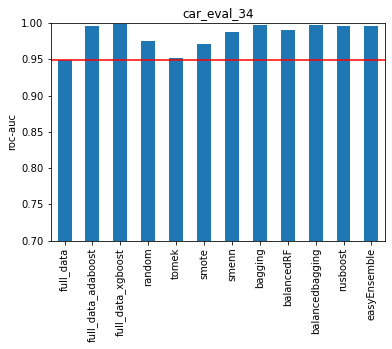

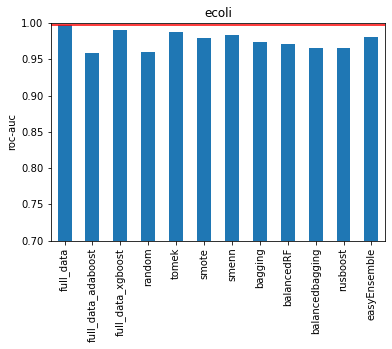

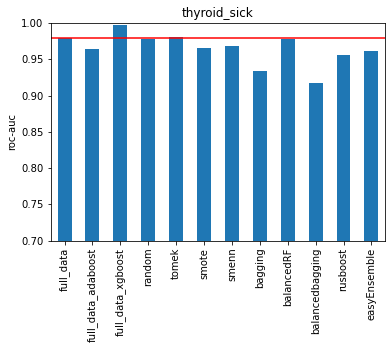

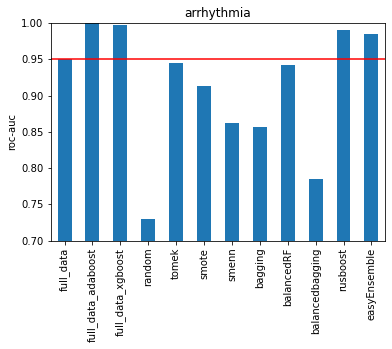

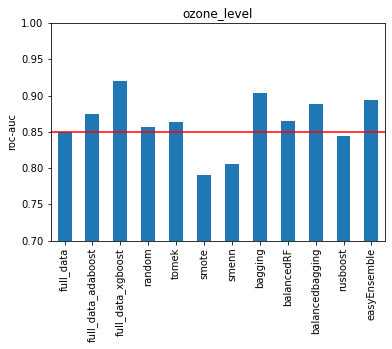

In [12]:
for dataset in datasets_ls:
    
    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
    plt.ylim(0.7, 1)
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

We see that boosting algorithms tend to outperform bagging algorithms. And adding resampling to bagging improves performance, in general, quite a bit.

We also see that in some cases, boosting alone outperforms resampling techniques.

Different methods has different performance on different datasets. There is no a single method that is best for all datasets.
